In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.io as pio

pio.renderers.default = "iframe"
import numpy as np
from ast import literal_eval
from decimal import Decimal

import seaborn as sns

In [101]:
names = {}
names[20] = [
    "seed",
    "depth",
    "window",
    "method",
    "budget",
    "stagei",
    "skills",
    "opt",
    "lr",
    "num_nodes",
    "num_layers",
    "epoch",
    "loss",
    "acc",
    "score",
    "wait",
    "patience",
    "test",
]
names[21] = [
    "seed",
    "depth",
    "window",
    "method",
    "stagei",
    "skills",
    "budget",
    "opt",
    "lr",
    "num_nodes",
    "num_layers",
    "epoch",
    "loss",
    "acc",
    "score",
    "wait",
    "patience",
    "test",
]
names[30] = [
    "seed",
    "depth",
    "window",
    "method",
    "stagei",
    "skills",
    "budget",
    "disc_thresh",
    "disc_steps",
    "opt",
    "lr",
    "num_nodes",
    "num_layers",
    "epoch",
    "loss",
    "acc",
    "wait",
    "patience",
    "test",
]
"seed,depth,window,mode,stagei,skill_str,budget_str,batch_size,opt,lr,num_nodes,num_layers,epoch,loss,acc,valid_score,wait,patience,test_score",


def get_df(v):
    if v >= 33 or True:
        n = None
    else:
        n = names[21]
    # elif v > 21:
    #     n = names[21]
    # else:
    #     n = names[v]
    # df = pd.read_csv(f"/storage1/fs1/chien-ju.ho/Active/tree/output{v}.txt", names=n)
    df = pd.read_csv(f"/home/n.saumik/gymnasium-test/output/output{v}.txt", names=n)
    # df = pd.concat([df1, df2])

    if "stagei" not in df.columns:
        df["stagei"] = 0
    df = df.rename(
        columns={
            "skill_str": "skills",
            "budget_str": "budget",
            "decisions": "depth",
            "nodes": "num_nodes",
            "layers": "num_layers",
            "mode": "method",
            "discrim_steps": "disc_steps",
        }
    )

    # df['dup'] = (df.epoch == 0).astype(int)
    # df['dup'] = df.groupby(categories)['dup'].cumsum()
    # df = df.groupby(categories + ['dup']).filter(lambda x: x['wait'].max() == x['patience'].iloc[0])
    # df = df[df.wait == 0]
    # df = df.drop_duplicates(categories + ['dup'], keep='last')
    # df = df.groupby(categories).mean().reset_index()
    df = df[~df.stagei.isna()]
    df["stagei"] = df.stagei.astype(int)
    df["skillsi"] = df.apply(
        lambda x: "_".join(x.skills.split("_")[: x.stagei + 1]), axis=1
    )
    df["num_nodes"] = df[["num_nodes", "num_layers"]].apply(tuple, axis=1)
    df["opt"] = df.opt + "-" + df.lr.astype(str)
    if v >= 30 or True:
        df[["budget_type", "budget"]] = df.budget.str.split("_", expand=True)
        df["budget"] = np.log2(df.budget.astype(int))
        df["crit_freq"] = df.method.apply(lambda x: x.split("-")[-1])
        df["crit_gen"] = df.method.apply(lambda x: "-".join(x.split("-")[:-1]))
    elif v >= 21:
        df[["budget_type", "budget"]] = df.budget.str.split("_", expand=True)
        df["budget"] = np.log2(df.budget.astype(int))
        df["crit_freq"] = df.method.apply(lambda x: x.split("-")[-1])
        df["crit_gen"] = df.method.apply(lambda x: "-".join(x.split("-")[:-1]))
    elif v >= 20:
        df["budget"] = np.log2(df.budget)
    return df

In [128]:
%%time
# df_all = get_df(36)
df_all = pd.concat([get_df(3), get_df(37)])
df_all.shape

CPU times: user 313 ms, sys: 2.56 ms, total: 316 ms
Wall time: 392 ms


(16795, 24)

In [53]:
df_all = get_df(35)
df_all = df_all[200000:]
df_all = df_all[df_all.batch_size==1]
df_all = df_all[df_all.method.isin(["crit-8-10-0-0.2", "random"])]
df_all = df_all[df_all.depth == 4]

budget,8.0,10.0,12.0,14.0,16.0,18.0
skillsi,,,,,,
1 (Lowest),400,400,400,400,400,396
2,200,200,200,200,200,199
3,200,200,200,200,200,199
4 (Highest),200,200,200,200,200,199


AttributeError: Use the `.axes` attribute when facet variables are assigned.

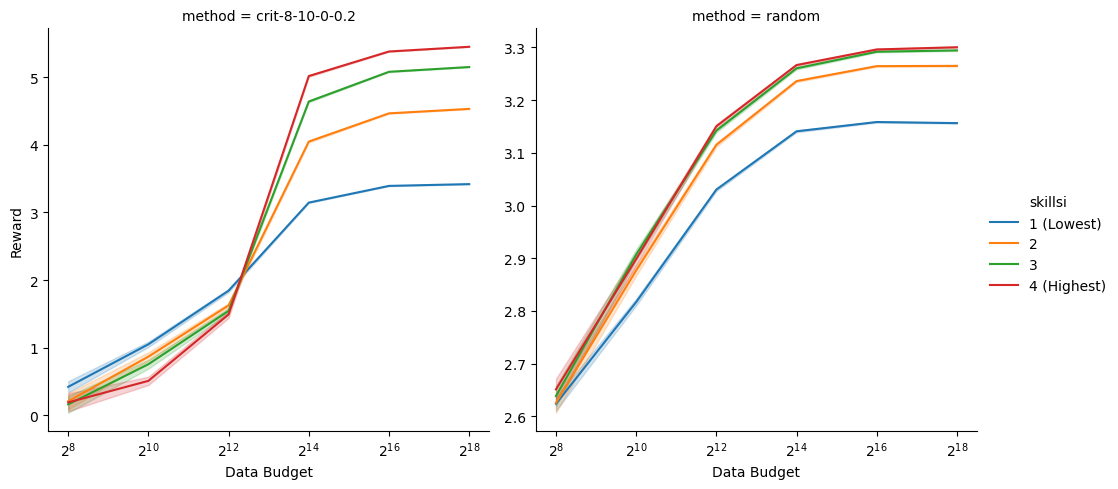

In [129]:
tree_key1 = {
    "A": "1 (Lowest)",
    "B": "2",
    "C": "3",
    "D": "4 (Highest)",
}

df = df_all.copy()
df = df[df.skillsi.isin(tree_key1)]
df["skillsi"] = df.skillsi.replace(tree_key1)
df = df.sort_values(["budget", "skillsi", "method"])
df = df[df.budget > 6]
# df = df[df.batch_size == 32]
# df = df[df.method != 'crit-0-10-8-0.2']
df["budget_str"] = df.budget.apply(lambda x: f"$2^{{{int(x)}}}$")

display(df.pivot_table(index='skillsi', columns='budget', values='seed', aggfunc='count'))


g = sns.relplot(
    kind="line",
    data=df,
    x="budget_str",
    y="test_score",
    hue="skillsi",
    col="method",
    # row="method",
    facet_kws={"sharey": False},
    errorbar="se",
)

g.set_axis_labels("Data Budget", "Reward")
# g.legend.remove()
handles, labels = g.ax.get_legend_handles_labels()
legend = g.ax.legend(handles=handles, labels=labels, title="Vision Amount", loc="upper left")  
g.fig.set_size_inches(10, 5)

g.ax.xaxis.label.set_size(20)
g.ax.yaxis.label.set_size(20)
g.ax.tick_params(axis='both', which='major', labelsize=16) # For ticks
legend.get_title().set_fontsize(20)
for text in legend.get_texts():  # Legend text size
    text.set_fontsize(16)
g.ax.set_ylim(bottom=0)
# plt.savefig("images/tree41.png", bbox_inches='tight')
plt.show()


# df = (
#     df.groupby(["depth", "budget", "skillsi", "crit_gen", "crit_freq"])
#     .test.agg(["mean", "sem", "count"])
#     .reset_index()
# )
# df["budget"] = "2^" + df.budget.astype(int).astype(str)
# fig = px.line(
#     data_frame=df,
#     x="budget",
#     y="mean",
#     error_y="sem",  # Assuming 'se' column exists for standard error
#     color="skillsi",
#     color_discrete_sequence=px.colors.qualitative.G10,
#     # facet_row="crit_gen",
#     # facet_col="crit_freq",
#     # facet_row_spacing=0.07,  # Adjust spacing between rows
#     # facet_col_spacing=0.07,  # Adjust spacing between columns
#     height=500,  # Adjust overall height of the figure
#     width=1000,  # Adjust overall width of the figure
# )

# fig.update_yaxes(matches=None)
# fig.update_xaxes(title_text="Data Budget")
# fig.update_yaxes(title_text="Task Performance")
# fig.update_layout(legend_title_text="Data Skill")
# fig.show()

budget,8.0,10.0,12.0,14.0,16.0,18.0
skillsi,,,,,,
high-skill,200,200,200,200,200,199
low-skill complex,200,200,200,200,200,199
low-skill easy,200,200,200,200,200,199


AttributeError: Use the `.axes` attribute when facet variables are assigned.

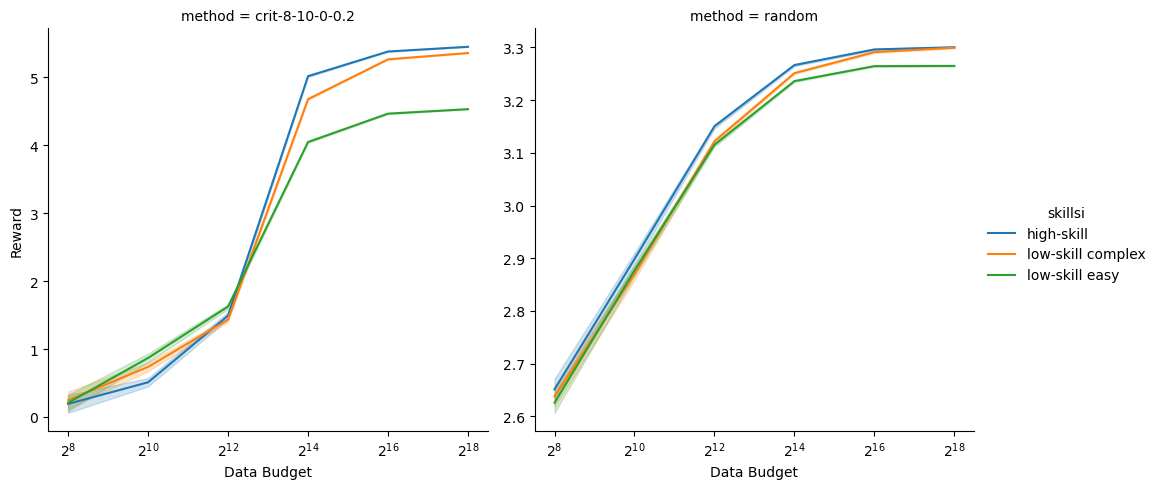

In [130]:
tree_key1 = {
    "b": "low-skill complex",
    "B": "low-skill easy",
    "D": "high-skill",
}

df = df_all.copy()
df = df[df.skillsi.isin(tree_key1)]
df["skillsi"] = df.skillsi.replace(tree_key1)
df = df.sort_values(["budget", "skillsi", "method"])
df = df[df.budget > 6]
# df = df[df.batch_size == 1]
df = df[df.method != 'crit-0-10-8-0.2']
df["budget_str"] = df.budget.apply(lambda x: f"$2^{{{int(x)}}}$")

display(df.pivot_table(index='skillsi', columns='budget', values='seed', aggfunc='count'))



g = sns.relplot(
    kind="line",
    data=df,
    x="budget_str",
    y="test_score",
    hue="skillsi",
    # row="batch_size",
    col="method",
    facet_kws={"sharey": False},
    errorbar="se",
)

g.set_axis_labels("Data Budget", "Reward")
# g.legend.remove()
handles, labels = g.ax.get_legend_handles_labels()
legend = g.ax.legend(handles=handles, labels=labels, title="Vision Amount", loc="upper left")  
g.fig.set_size_inches(10, 5)

g.ax.xaxis.label.set_size(20)
g.ax.yaxis.label.set_size(20)
g.ax.tick_params(axis='both', which='major', labelsize=16) # For ticks
legend.get_title().set_fontsize(20)
for text in legend.get_texts():  # Legend text size
    text.set_fontsize(16)
g.ax.set_ylim(bottom=0)
# plt.savefig("images/tree41.png", bbox_inches='tight')
plt.show()


# df = (
#     df.groupby(["depth", "budget", "skillsi", "crit_gen", "crit_freq"])
#     .test.agg(["mean", "sem", "count"])
#     .reset_index()
# )
# df["budget"] = "2^" + df.budget.astype(int).astype(str)
# fig = px.line(
#     data_frame=df,
#     x="budget",
#     y="mean",
#     error_y="sem",  # Assuming 'se' column exists for standard error
#     color="skillsi",
#     color_discrete_sequence=px.colors.qualitative.G10,
#     # facet_row="crit_gen",
#     # facet_col="crit_freq",
#     # facet_row_spacing=0.07,  # Adjust spacing between rows
#     # facet_col_spacing=0.07,  # Adjust spacing between columns
#     height=500,  # Adjust overall height of the figure
#     width=1000,  # Adjust overall width of the figure
# )

# fig.update_yaxes(matches=None)
# fig.update_xaxes(title_text="Data Budget")
# fig.update_yaxes(title_text="Task Performance")
# fig.update_layout(legend_title_text="Data Skill")
# fig.show()

budget,8.0,10.0,12.0,14.0,16.0,18.0
skillsi,,,,,,
Filtered BC,200.0,200.0,200.0,200.0,200.0,199.0
Filtered BC-SBC,200.0,200.0,200.0,200.0,198.0,2.0
Standard BC,200.0,200.0,200.0,200.0,200.0,21.0
Standard BC-SBC,200.0,200.0,200.0,200.0,200.0,NaN


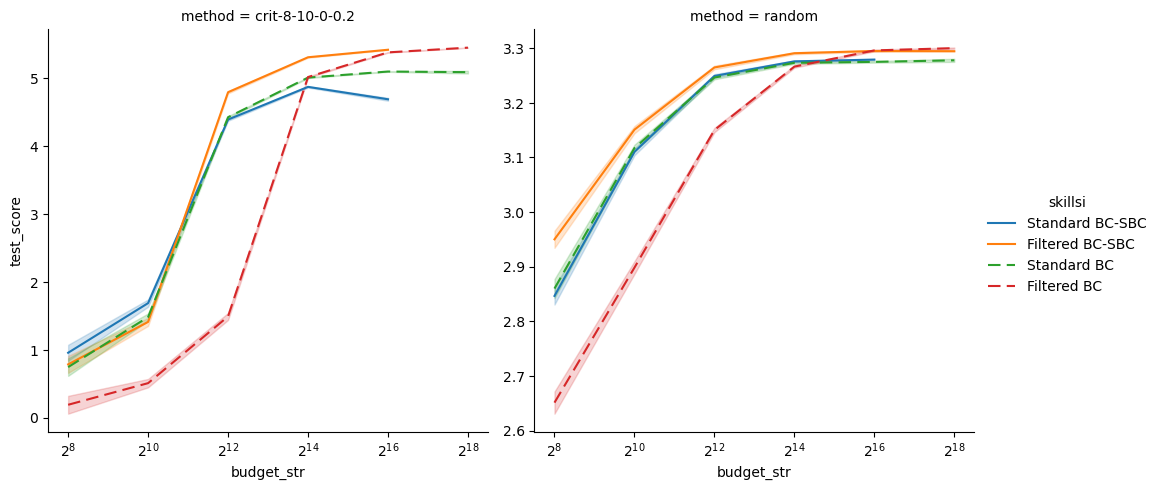

In [131]:
tree_key2 = {
    "D": "Filtered BC",
    "ABCD_BCD_CD_D": "Filtered BC-SBC",
    "ABCD": "Standard BC",
    "A_AB_ABC_ABCD": "Standard BC-SBC",
}

df = df_all.copy()
df = df[df.skillsi.isin(tree_key2)]
df["skillsi"] = df.skillsi.replace(tree_key2)
df = df.sort_values("skillsi", key=lambda x: x.map({
    "Standard BC-SBC":0,
    "Filtered BC-SBC":1,
    "Standard BC":2,
    "Filtered BC":3,
}))
df = df.sort_values(["budget", "method"], kind="stable").reset_index()
df = df[df.budget > 6]
# df['budget'] += 6
df["budget_str"] = df.budget.apply(lambda x: f"$2^{{{int(x)}}}$")

display(df.pivot_table(index='skillsi', columns='budget', values='seed', aggfunc='count'))

g = sns.relplot(
    kind="line",
    data=df,
    x="budget_str",
    y="test_score",
    col="method",
    hue="skillsi",
    style="skillsi",
    dashes=["", "", (6,3), (6,3)],
    errorbar="se",
    facet_kws={"sharey": False},
)

# g.set_axis_labels("Data Budget", "Reward")
# g.legend.remove()
# handles, labels = g.ax.get_legend_handles_labels()
# legend = g.ax.legend(handles=handles, labels=labels, title="Training Method", loc="upper left")  
# g.fig.set_size_inches(10, 5)

# g.ax.xaxis.label.set_size(20)
# g.ax.yaxis.label.set_size(20)
# g.ax.tick_params(axis='both', which='major', labelsize=16) # For ticks
# legend.get_title().set_fontsize(20)
# for text in legend.get_texts():  # Legend text size
#     text.set_fontsize(16)
# g.ax.set_ylim(bottom=0)
# # plt.savefig("images/tree42.png", bbox_inches='tight')
# plt.show()

In [ ]:
tree_key2 = {
    "D": "Filtered BC",
    "ABCD_BCD_CD_D": "Filtered BC-SBC",
    "ABCD": "Standard BC",
    "A_AB_ABC_ABCD": "Standard BC-SBC",
}

df = df_all.copy()
df = df[df.skillsi.isin(tree_key2)]
df["skillsi"] = df.skillsi.replace(tree_key2)
df = df.sort_values("skillsi", key=lambda x: x.map({
    "Standard BC-SBC":0,
    "Filtered BC-SBC":1,
    "Standard BC":2,
    "Filtered BC":3,
}))
df = df.sort_values("budget", kind="stable").reset_index()
df = df[df.budget < 17]
df['budget'] += 6
df["budget_str"] = df.budget.apply(lambda x: f"$2^{{{int(x)}}}$")


g = sns.relplot(
    kind="line",
    data=df,
    x="budget",
    y="test",
    hue="skillsi",
    style="skillsi",
    dashes=["", "", (6,3), (6,3)],
    errorbar="se",
)

g.set_axis_labels("Data Budget", "Reward")
g.legend.remove()
handles, labels = g.ax.get_legend_handles_labels()
legend = g.ax.legend(handles=handles, labels=labels, title="Training Method", loc="upper left")  
g.fig.set_size_inches(10, 5)

g.ax.xaxis.label.set_size(20)
g.ax.yaxis.label.set_size(20)
g.ax.tick_params(axis='both', which='major', labelsize=16) # For ticks
legend.get_title().set_fontsize(20)
for text in legend.get_texts():  # Legend text size
    text.set_fontsize(16)
g.ax.set_ylim(bottom=0)
plt.savefig("images/tree42.png", bbox_inches='tight')
plt.show()








# df = (
#     df.groupby(["depth", "budget", "skillsi", "crit_gen", "crit_freq"])
#     .test.agg(["mean", "sem", "count"])
#     .reset_index()
# )
# df["budget"] = "$2^{" + df.budget.astype(int).astype(str) + "}$"

# fig = px.line(
#     data_frame=df,
#     x="budget",
#     y="mean",
#     error_y="sem",  # Assuming 'se' column exists for standard error
#     color="skillsi",
#     color_discrete_sequence=px.colors.qualitative.G10,
#     # facet_row="crit_gen",
#     # facet_col="crit_freq",
#     facet_row_spacing=0.07,  # Adjust spacing between rows
#     facet_col_spacing=0.07,  # Adjust spacing between columns
#     height=500,  # Adjust overall height of the figure
#     width=1000,  # Adjust overall width of the figure
# )

# fig.update_yaxes(matches=None)
# fig.update_xaxes(title_text="Data Budget")
# fig.update_yaxes(title_text="Task Performance")
# fig.update_layout(legend_title_text="Data Skill")
# fig.show()

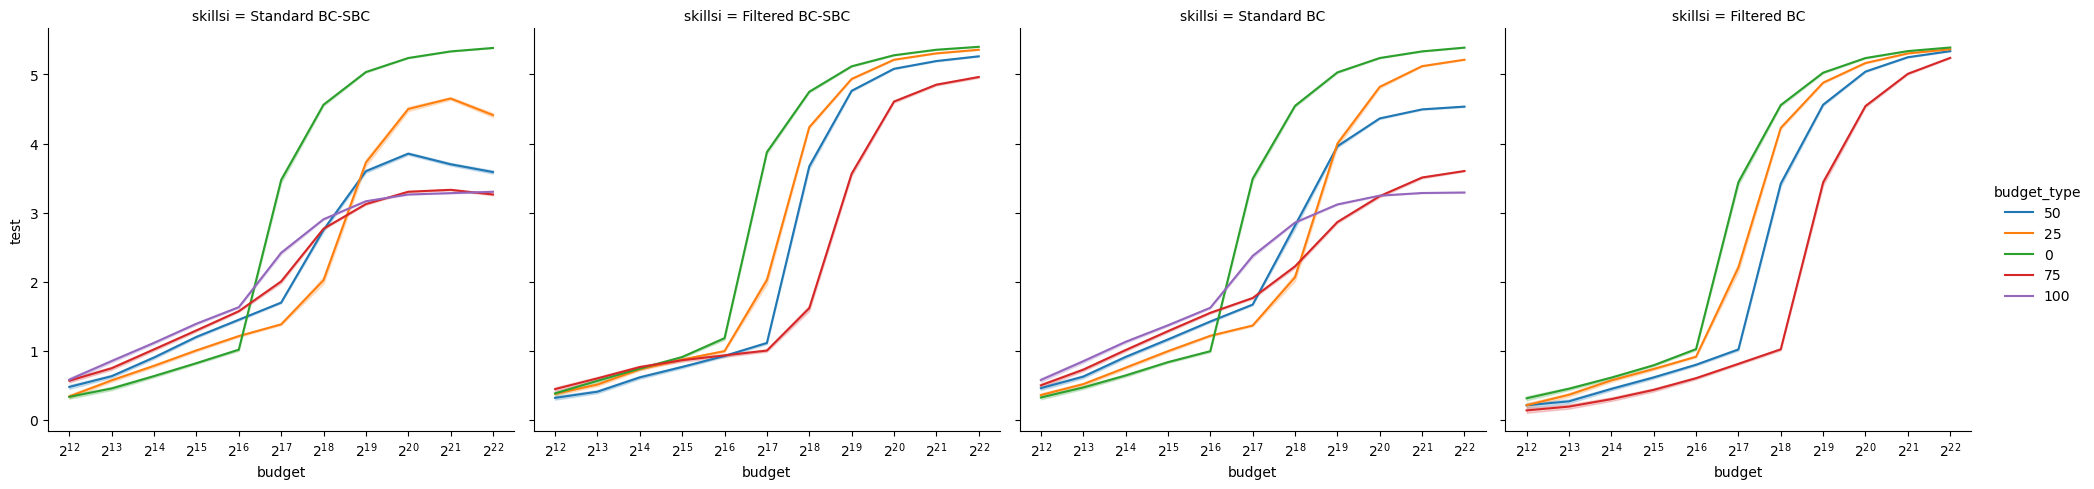

In [6]:
tree_key2s = {
    "D": "Filtered BC",
    "AD_D": "Filtered BC-SBC",
    "AD": "Standard BC",
    "A_AD": "Standard BC-SBC",
}

df = df_all.copy()
df = df[df.skillsi.isin(tree_key2s)]
df["skillsi"] = df.skillsi.replace(tree_key2s)
df = df.sort_values("skillsi", key=lambda x: x.map({
    "Standard BC-SBC":0,
    "Filtered BC-SBC":1,
    "Standard BC":2,
    "Filtered BC":3,
}))
df = df.sort_values("budget", kind="stable").reset_index()
df = df[df.budget < 17]
df['budget'] += 6
df["budget"] = df.budget.apply(lambda x: f"$2^{{{int(x)}}}$")


g = sns.relplot(
    kind="line",
    data=df,
    x="budget",
    y="test",
    hue="budget_type",
    # style="skillsi",
    col='skillsi',
    dashes=["", "", (6,3), (6,3)],
    errorbar="se",
)

# g.set_axis_labels("Data Budget", "Reward")
# g.legend.remove()
# handles, labels = g.ax.get_legend_handles_labels()
# legend = g.ax.legend(handles=handles, labels=labels, title="Training Method", loc="upper left")  
# g.fig.set_size_inches(10, 5)

# g.ax.xaxis.label.set_size(20)
# g.ax.yaxis.label.set_size(20)
# g.ax.tick_params(axis='both', which='major', labelsize=16) # For ticks
# legend.get_title().set_fontsize(20)
# for text in legend.get_texts():  # Legend text size
#     text.set_fontsize(16)
# g.ax.set_ylim(bottom=0)
# # plt.savefig("images/tree42.png", bbox_inches='tight')
# plt.show()

# Algo

In [ ]:
f"{seed};{decisions};{mode};{curr};{start_budget};{end_budget};{trial_inc};{budget_inc};{best_branch};{branch_vals};{budget};{loss_algo};{test_score_algo};{test_score_chosen};{test_score_equal};{test_score_high}",

In [48]:
df_algo = pd.read_csv(
    "/storage1/fs1/chien-ju.ho/Active/tree/algo7.txt",
    sep=";",
    names=[
        "seed",
        "decisions",
        "mode",
        "curr",
        "start",
        "end",
        "trial",
        "inc",
        "best_branch",
        "branch_vals",
        "budget",
        "valid_loss",
        "valid_test",
        "wp_chosen",
        "wp_equal",
        "wp_high",
    ],
)
df_algo[["A", "B", "C", "D"]] = (
    df_algo.budget.str.slice(1, -1).str.split(expand=True).astype(int)
)
df_algo["budget2"] = np.log2(df_algo[["A", "B", "C", "D"]].sum(axis=1))
# df_algo

In [60]:
df_algo.branch_vals.apply(lambda x: [x[0][0]])

0       [{]
1       [{]
2       [{]
3       [{]
4       [{]
       ... 
2344    [{]
2345    [{]
2346    [{]
2347    [{]
2348    [{]
Name: branch_vals, Length: 2349, dtype: object

In [58]:
df_algo[(df_algo.seed == 10) & (df_algo.curr == "rev")]

,seed,decisions,mode,curr,start,end,trial,inc,best_branch,branch_vals,budget,valid_loss,valid_test,wp_chosen,wp_equal,wp_high,A,B,C,D,budget2
56,10,4,crit-8-10-0-0.2,rev,16,262144,0.0625,2.0,1,"{0: (1.3348830938339233, 0.5080004974769461), ...",[ 5 21 5 5],1.656721,0.991108,0.236530,0.609826,-0.683184,5,21,5,5,5.169925
232,10,4,crit-8-10-0-0.2,rev,16,262144,0.0625,2.0,2,"{0: (1.1909751892089844, 0.3141684904661843), ...",[ 8 24 52 8],1.081442,0.481552,0.496803,-0.398086,0.442952,8,24,52,8,6.523562
468,10,4,crit-8-10-0-0.2,rev,16,262144,0.0625,2.0,1,"{0: (0.8789288997650146, 0.31710381262821574),...",[ 14 130 58 14],0.897855,0.550172,0.987490,0.164048,0.803397,14,130,58,14,7.754888
701,10,4,crit-8-10-0-0.2,rev,16,262144,0.0625,2.0,1,"{0: (0.7861677408218384, 0.7064541617484035), ...",[ 28 360 72 28],0.808329,0.927724,0.996771,0.721588,0.871193,28,360,72,28,8.930737
900,10,4,crit-8-10-0-0.2,rev,16,262144,0.0625,2.0,0,"{0: (0.7093768119812012, 1.2621570935981286), ...",[547 391 103 59],0.709377,1.262157,1.548725,0.744813,0.807980,547,391,103,59,10.103288
1086,10,4,crit-8-10-0-0.2,rev,16,262144,0.0625,2.0,1,"{0: (0.6954728364944458, 1.362745092962018), 1...",[ 616 1568 172 128],0.682211,1.487687,1.717695,0.589941,3.812986,616,1568,172,128,11.278449
1282,10,4,crit-8-10-0-0.2,rev,16,262144,0.0625,2.0,3,"{0: (0.670896053314209, 1.428740714827362), 1:...",[ 772 1724 328 2776],0.650430,2.298767,3.958391,1.095272,4.941819,772,1724,328,2776,12.451211
1526,10,4,crit-8-10-0-0.2,rev,16,262144,0.0625,2.0,3,"{0: (0.41767945885658264, 4.039043327258613), ...",[1122 2074 678 8726],0.386736,4.285380,4.727849,4.583373,5.185960,1122,2074,678,8726,13.621136
1758,10,4,crit-8-10-0-0.2,rev,16,262144,0.0625,2.0,3,"{0: (0.27268368005752563, 5.070200164103937), ...",[ 1910 2862 1466 22114],0.274131,5.126703,5.196870,3.235165,5.320346,1910,2862,1466,22114,14.791163
1956,10,4,crit-8-10-0-0.2,rev,16,262144,0.0625,2.0,3,"{0: (0.2713381052017212, 5.068472769829397), 1...",[ 3682 4634 3238 52238],0.227176,5.333775,5.322114,3.388668,5.367324,3682,4634,3238,52238,15.961088


In [57]:
pd.set_option("display.max_columns", 500)

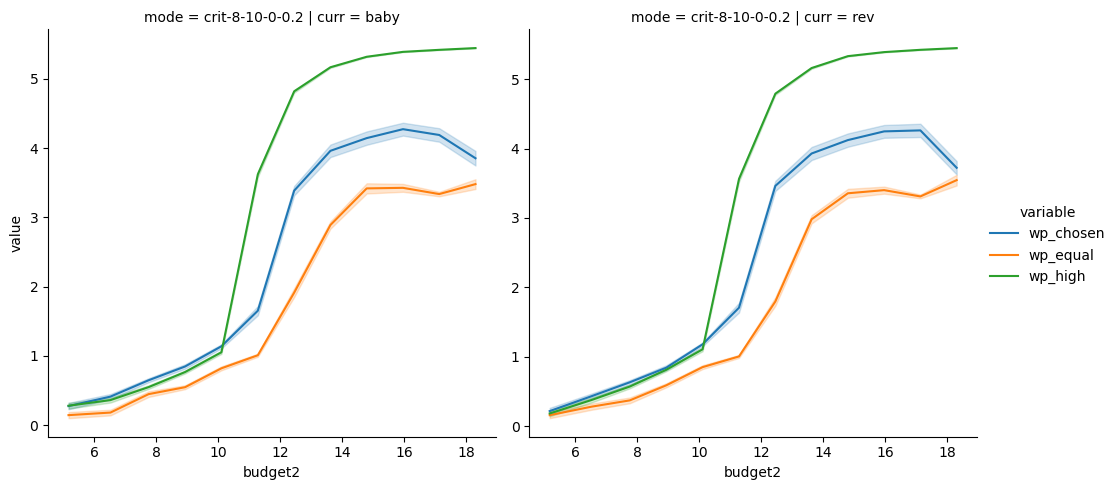

In [49]:
df_ = df_algo.melt(
    id_vars=[
        "seed",
        "decisions",
        "mode",
        "curr",
        "start",
        "end",
        "trial",
        "inc",
        "budget",
        "budget2",
    ],
    value_vars=["wp_chosen", "wp_equal", "wp_high"],
)

g = sns.relplot(
    data=df_[df_.budget2 <= 20],
    x="budget2",
    y="value",
    hue="variable",
    kind="line",
    row="mode",
    col="curr",
    errorbar="se",
    facet_kws={"sharey": False},
)
display(g.figure)
plt.close(g.figure)

In [53]:
df_[(df_.seed == 50) & (df_.curr == "baby")]

,seed,decisions,mode,curr,start,end,trial,inc,budget,budget2,variable,value
113,50,4,crit-8-10-0-0.2,baby,16,262144,0.0625,2.0,[ 5 21 5 5],5.169925,wp_chosen,0.900182
340,50,4,crit-8-10-0-0.2,baby,16,262144,0.0625,2.0,[ 8 24 8 52],6.523562,wp_chosen,0.338473
536,50,4,crit-8-10-0-0.2,baby,16,262144,0.0625,2.0,[ 14 30 114 58],7.754888,wp_chosen,0.929392
734,50,4,crit-8-10-0-0.2,baby,16,262144,0.0625,2.0,[ 28 44 344 72],8.930737,wp_chosen,0.888238
945,50,4,crit-8-10-0-0.2,baby,16,262144,0.0625,2.0,[ 59 75 863 103],10.103288,wp_chosen,1.070086
1174,50,4,crit-8-10-0-0.2,baby,16,262144,0.0625,2.0,[1236 144 932 172],11.278449,wp_chosen,2.272631
1354,50,4,crit-8-10-0-0.2,baby,16,262144,0.0625,2.0,[1392 300 3580 328],12.451211,wp_chosen,3.925307
1593,50,4,crit-8-10-0-0.2,baby,16,262144,0.0625,2.0,[1742 650 9530 678],13.621136,wp_chosen,4.797482
1765,50,4,crit-8-10-0-0.2,baby,16,262144,0.0625,2.0,[ 2530 1438 22918 1466],14.791163,wp_chosen,4.839074
1988,50,4,crit-8-10-0-0.2,baby,16,262144,0.0625,2.0,[ 4302 3210 24690 31590],15.961088,wp_chosen,4.989230


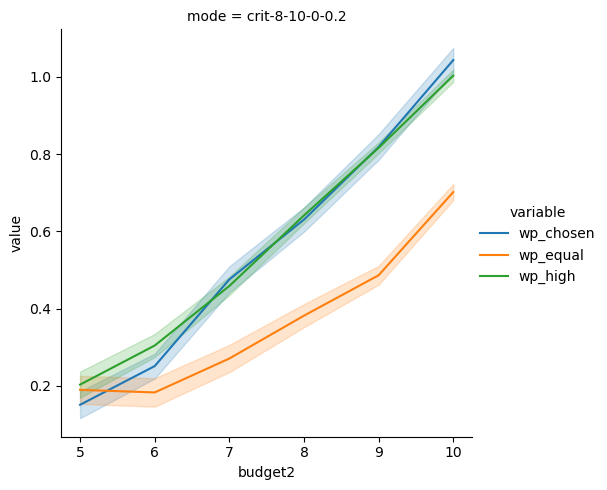

In [22]:
df_ = df_algo.melt(
    id_vars=[
        "seed",
        "decisions",
        "mode",
        "start",
        "end",
        "trial",
        "inc",
        "budget",
        "budget2",
    ],
    value_vars=["wp_chosen", "wp_equal", "wp_high"],
)

g = sns.relplot(
    data=df_[df_.budget2 <= 10],
    x="budget2",
    y="value",
    hue="variable",
    kind="line",
    row="mode",
    errorbar="se",
    facet_kws={"sharey": False},
)
display(g.figure)
plt.close(g.figure)

In [ ]:
df_ = df_cats20.sort_values(["budget", "method"])

df_ = df_[
    df_.label.isin(
        [
            # "updown",
            # "up",
            "down",
            "mixed",
            "onepass",
            # "lowf",
            "highf",
            # "low",
            # "high",
            # "A","B","C","D",
        ]
    )
]

g = sns.relplot(
    data=df_,
    x="budget",
    y="test",
    hue="label",
    row="method",
    col="depth",
    kind="line",
    errorbar="se",
    facet_kws={"sharey": False},
)
plt.xticks(np.arange(df_.budget.min(), df_.budget.max() + 1, 1))
display(g.figure)
plt.close(g.figure)

In [ ]:
g = sns.relplot(
    data=df_.query("budget <= 10"),
    x="budget",
    y="test",
    hue="label",
    row="method",
    col="depth",
    kind="line",
    errorbar="se",
    facet_kws={"sharey": False},
)
# plt.xticks(np.arange(df_.budget.min(),df_.budget.max()+1,1))
display(g.figure)
plt.close(g.figure)

In [ ]:
%%time
df19 = get_df(19)

In [ ]:
df19

In [ ]:
df19_ = pd.concat([df19, df18_])
df19_

In [ ]:
df_cats = []
for decisions in [2, 3, 4]:

    mixed = "ABCD"[:decisions]
    high = mixed[-1]
    onepass = "_".join(mixed)
    up, updown, down = [], [], []

    for i in range(1, decisions):
        up.append(mixed[:i])
        updown.append(mixed[:i])

    up.append(mixed)
    updown.append(mixed)
    down.append(mixed)

    for i in range(1, decisions):
        down.append(mixed[i:])
        updown.append(mixed[i:])

    up, updown, down = "_".join(up), "_".join(updown), "_".join(down)
    skill_categories = {
        "up": up,
        "updown": updown,
        "down": down,
        "mixed": mixed,
        "onepass": onepass,
    }

    for label, cat in skill_categories.items():
        df_ = df19[df19.depth == decisions]
        df_ = df_[df_.skillsi.apply(lambda x: cat.startswith(x))]
        df_ = (
            df_.groupby(["seed", "depth", "method", "budget"]).test.max().reset_index()
        )
        df_["skills"] = cat
        df_["label"] = label
        df_["depth"] = decisions
        df_cats.append(df_)

    df_ = df18_[df18_.depth == decisions]
    df_ = df_[df_.skillsi.apply(lambda x: high.startswith(x))]
    df_ = df_.groupby(["seed", "depth", "method", "budget"]).test.max().reset_index()
    df_["skills"] = high
    df_["budget"] *= 4
    df_["label"] = "high"
    df_["depth"] = decisions
    df_cats.append(df_)


df_cats = pd.concat(df_cats)
df_cats

In [ ]:
df_ = df_cats.sort_values("budget").astype({"budget": "str"})

g = sns.relplot(
    data=df_[df_.label.isin(["mixed", "onepass", "high"])],
    x="budget",
    y="test",
    hue="label",
    row="method",
    col="depth",
    kind="line",
    errorbar="se",
    facet_kws={"sharey": False},
)
display(g.figure)
plt.close(g.figure)

methods = list(df_.method.unique())


def color_alternate_columns(row):
    def get_style(idx, value):
        style = ""
        if (idx[0] + methods.index(row.name[0])) % 2 == 0:
            style += "background-color: #E6F3FF;"
        else:
            style += "background-color: #E6FFE6;"

        max_val = max(value_ for idx_, value_ in row.items() if idx_[0] == idx[0])
        if value == max_val:
            style += "font-weight: bold;"
        return style

    colors = [get_style(idx, value) for idx, value in row.items()]
    return colors


pivoted = df_.pivot_table(
    index=["method", "budget"], columns=["depth", "label"], values="test"
)
display(pivoted.style.apply(color_alternate_columns, axis=1).format(precision=3))


def color_alternate_columns(row):
    def get_style(idx, value):
        style = ""
        if (idx[0] + methods.index(row.name[0])) % 2 == 0:
            style += "background-color: #E6F3FF;"
        else:
            style += "background-color: #E6FFE6;"
        return style

    colors = [get_style(idx, value) for idx, value in row.items()]
    return colors


pivoted = df_.pivot_table(
    index=["method", "budget"], columns=["depth", "label"], values="seed", aggfunc=len
)
display(pivoted.style.apply(color_alternate_columns, axis=1).format(precision=0))

In [ ]:
df_[(df_.method == "normal-2-0") & (df_.depth == 4)].pi

In [ ]:
names = [
    "seed",
    "depth",
    "window",
    "method",
    "budget",
    "vision",
    "temp",
    "opt",
    "lr",
    "num_nodes",
    "num_layers",
    "epoch",
    "loss",
    "acc",
    "score",
    "wait",
    "patience",
    "test",
]

categories = [
    "seed",
    "depth",
    "window",
    "method",
    "budget",
    "vision",
    "temp",
    "opt",
    "lr",
    "num_nodes",
    "num_layers",
    "patience",
]


def get_df(v):
    df = pd.read_csv(
        f"/storage1/fs1/chien-ju.ho/Active/tree/output{v}.txt", names=names
    )
    df["dup"] = (df.epoch == 0).astype(int)
    df["dup"] = df.groupby(categories)["dup"].cumsum()
    df = df.groupby(categories + ["dup"]).filter(
        lambda x: x["wait"].max() == x["patience"].iloc[0]
    )
    df = df[df.wait == 0]
    df = df.drop_duplicates(categories + ["dup"], keep="last")
    df = df.groupby(categories).mean().reset_index()
    # df['skill'] = df.apply(lambda x: f"({x.vision}, {x.temp})", axis=1)
    return df

In [ ]:
%%time
df18 = get_df(18)

In [ ]:
df18

In [ ]:
df18_ = (
    df18[df18.temp == 0]
    .groupby(["seed", "depth", "method", "vision", "budget"])
    .test.max()
    .reset_index()
)
df18_["skills"] = df18_.vision.replace({1: "A", 2: "B", 3: "C", 4: "D"})
df18_["skillsi"] = df18_.skills
df18_["stagei"] = 1
df18_

In [ ]:
# skill = 'temp'
skill = "vision"

if skill == "temp":
    df_ = df18[df18.temp != 0]
else:
    df_ = df18[df18.temp == 0]
df_ = df_.astype({"budget": "str", "vision": "str", "temp": "str"})

g = sns.relplot(
    data=df_,
    x="budget",
    y="test",
    hue=skill,
    row="method",
    col="depth",
    kind="line",
    errorbar="se",
    facet_kws={"sharey": False},
)
display(g.figure)
plt.close(g.figure)

methods = list(df_.method.unique())


def color_alternate_columns(row):
    def get_style(idx, value):
        style = ""
        if (idx[0] + methods.index(row.name[0])) % 2 == 0:
            style += "background-color: #E6F3FF;"
        else:
            style += "background-color: #E6FFE6;"

        max_val = max(value_ for idx_, value_ in row.items() if idx_[0] == idx[0])
        if value == max_val:
            style += "font-weight: bold;"
        return style

    colors = [get_style(idx, value) for idx, value in row.items()]
    return colors


pivoted = df_.pivot_table(
    index=["method", "budget"], columns=["depth", skill], values="test"
)
display(pivoted.style.apply(color_alternate_columns, axis=1).format(precision=3))


def color_alternate_columns(row):
    def get_style(idx, value):
        style = ""
        if (idx[0] + methods.index(row.name[0])) % 2 == 0:
            style += "background-color: #E6F3FF;"
        else:
            style += "background-color: #E6FFE6;"
        return style

    colors = [get_style(idx, value) for idx, value in row.items()]
    return colors


pivoted = df_.pivot_table(
    index=["method", "budget"], columns=["depth", skill], values="seed", aggfunc=len
)
display(pivoted.style.apply(color_alternate_columns, axis=1).format(precision=0))